# Upload the Dataset File

In [1]:
# Upload the dataset csv file
from google.colab import files
uploaded = files.upload()

Saving StudentPerformanceFactors.csv to StudentPerformanceFactors.csv


# Import Libraries

In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

# Apply Preprocessing to the Dataset

In [29]:
# Categorize the label to create a categorization model
def categorize_exam_score(score):
    if score < 66:
        return 'Low'
    elif 66 <= score < 69:
        return 'Medium'
    elif score >= 69:
        return 'High'

In [30]:
data = pd.read_csv('StudentPerformanceFactors.csv')

# Apply the categorization function to categorize Exam_Score
data['Exam_Score_Category'] = data['Exam_Score'].apply(categorize_exam_score)

# Count occurrences of each category
category_counts = data['Exam_Score_Category'].value_counts()

# Print the counts
print(category_counts)

# Drop the original numerical label
data.drop(columns=['Exam_Score'], inplace=True)

# Replace missing data with a random data from the column
for column in data.columns:
  if data[column].isnull().sum() > 0:  # Check if there are missing values
    # Sample randomly from non-missing values in the column
    random_values = data[column].dropna().sample(data[column].isnull().sum(), replace=True)
    random_values.index = data[data[column].isnull()].index  # Align indices
    data.loc[data[column].isnull(), column] = random_values

# Normalization of numerical features
scaler = MinMaxScaler()
data[['Hours_Studied', 'Attendance', 'Sleep_Hours', 'Previous_Scores', 'Tutoring_Sessions', 'Physical_Activity']] = scaler.fit_transform(data[['Hours_Studied', 'Attendance', 'Sleep_Hours','Previous_Scores','Tutoring_Sessions','Physical_Activity']])

# Label encoding for categorical features
le = LabelEncoder()

categorical_columns = [
    'Parental_Involvement', 'Access_to_Resources', 'Internet_Access', 'Family_Income', 'Teacher_Quality', 'Parental_Education_Level', 'Distance_from_Home', 'Exam_Score_Category'
]

for column in categorical_columns:
    data[column] = le.fit_transform(data[column])


# Map integer-encoded values back to class names for Exam_Score_Category, to ensure the order of the label matches the encoded values
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Label Mapping for Exam_Score_Category:", label_mapping)

# Define class labels based on the integer mapping
class_labels = list(label_mapping.keys())
print("Class Labels in Order:", class_labels)

print(data.head())

# Define features (X) and label (y)
X = data.drop(columns=['Exam_Score_Category'])
y = data['Exam_Score_Category']

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# One-hot encode the labels, for later use in Neural Network and ROC-AUC calculation
y_train_encoded = to_categorical(y_train, num_classes=3)
y_test_encoded = to_categorical(y_test, num_classes=3)

Exam_Score_Category
High      2249
Medium    2227
Low       2131
Name: count, dtype: int64
Label Mapping for Exam_Score_Category: {'High': 0, 'Low': 1, 'Medium': 2}
Class Labels in Order: ['High', 'Low', 'Medium']
   Hours_Studied  Attendance  Parental_Involvement  Access_to_Resources  \
0       0.511628       0.600                     1                    0   
1       0.418605       0.100                     1                    2   
2       0.534884       0.950                     2                    2   
3       0.651163       0.725                     1                    2   
4       0.418605       0.800                     2                    2   

   Sleep_Hours  Previous_Scores  Internet_Access  Tutoring_Sessions  \
0     0.500000             0.46                1              0.000   
1     0.666667             0.18                1              0.250   
2     0.500000             0.82                1              0.250   
3     0.666667             0.96                1   

# Implement the Random Forest Model

Fitting 5 folds for each of 192 candidates, totalling 960 fits
Best Parameters: {'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 12, 'n_estimators': 150}
Best Cross-Validation Accuracy: 0.7785
Test Accuracy: 77.26%
Test Precision: 77.69%
Test Recall: 77.26%
Test F1 Score: 77.43%
Test ROC AUC Score: 91.85%


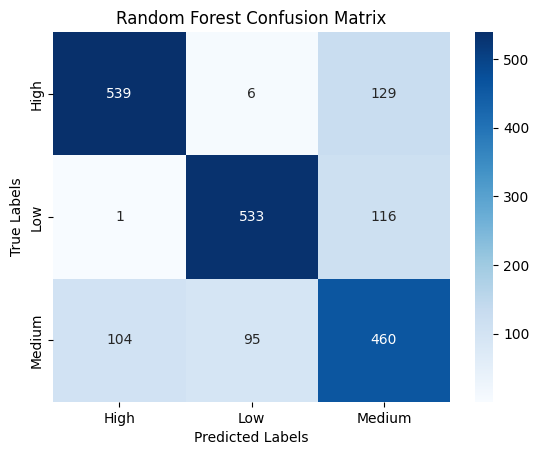

Classification Report:
              precision    recall  f1-score   support

        High       0.84      0.80      0.82       674
         Low       0.84      0.82      0.83       650
      Medium       0.65      0.70      0.67       659

    accuracy                           0.77      1983
   macro avg       0.78      0.77      0.77      1983
weighted avg       0.78      0.77      0.77      1983

                     Feature  Importance
1                 Attendance    0.490272
0              Hours_Studied    0.238245
5            Previous_Scores    0.075803
7          Tutoring_Sessions    0.033581
3        Access_to_Resources    0.032257
2       Parental_Involvement    0.025595
4                Sleep_Hours    0.019037
11  Parental_Education_Level    0.018647
10         Physical_Activity    0.017590
12        Distance_from_Home    0.016561
8              Family_Income    0.015346
9            Teacher_Quality    0.011134
6            Internet_Access    0.005932


In [31]:
# Random Forest grid search for finding optimum parameters
param_grid = {
    'max_depth': [4, 6, 8],  # Test different tree depths
    'n_estimators': [100, 120, 150, 180],  # Number of trees in the forest
    'min_samples_split': [2, 5, 10, 12],  # Minimum samples to split a node
    'min_samples_leaf': [1, 2, 4, 6]     # Minimum samples at a leaf node
}

# Initialize the Random Forest Classifier model
rf_model = RandomForestClassifier(random_state=42)

# Use GridSearchCV to tune hyperparameters
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, scoring='accuracy', cv=5, verbose=2, n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Accuracy: {grid_search.best_score_:.4f}")

# Train the model with the best parameters
best_rf_model = grid_search.best_estimator_

# Make prediction on the test set
y_pred = best_rf_model.predict(X_test)

# Predict probabilities
y_pred_probs = best_rf_model.predict_proba(X_test)

# Evaluate on the test set
rf_test_accuracy = accuracy_score(y_test, y_pred)
rf_precision = precision_score(y_test, y_pred, average='weighted')
rf_recall = recall_score(y_test, y_pred, average='weighted')
rf_f1 = f1_score(y_test, y_pred, average='weighted')
rf_roc_auc = roc_auc_score(y_test_encoded, y_pred_probs, multi_class='ovr', average='weighted')

print(f"Test Accuracy: {rf_test_accuracy * 100:.2f}%")
print(f"Test Precision: {rf_precision * 100:.2f}%")
print(f"Test Recall: {rf_recall * 100:.2f}%")
print(f"Test F1 Score: {rf_f1 * 100:.2f}%")
print(f"Test ROC AUC Score: {rf_roc_auc * 100:.2f}%")


# Confusion matrix as heatmap, to improve interpretability
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Random Forest Confusion Matrix')
plt.show()

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_labels))

# Display feature importance
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(feature_importances)

# Implement the Neural Network Model

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3501 - loss: 1.2653 - val_accuracy: 0.4346 - val_loss: 1.0557
Epoch 2/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4209 - loss: 1.0664 - val_accuracy: 0.4984 - val_loss: 1.0135
Epoch 3/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4455 - loss: 1.0244 - val_accuracy: 0.5459 - val_loss: 0.9508
Epoch 4/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4973 - loss: 0.9739 - val_accuracy: 0.5946 - val_loss: 0.8884
Epoch 5/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5510 - loss: 0.9075 - val_accuracy: 0.5924 - val_loss: 0.8292
Epoch 6/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5771 - loss: 0.8656 - val_accuracy: 0.6216 - val_loss: 0.7933
Epoch 7/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5952 - loss: 0.8176 - val_accuracy: 0.6346 - val_loss: 0.7583
Epoch 8/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6439 - loss: 0.7682 - val_accuracy: 0.6562 - val_

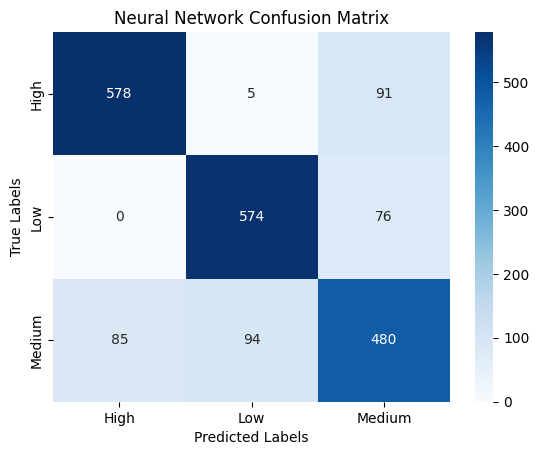

Classification Report:
              precision    recall  f1-score   support

        High       0.87      0.86      0.86       674
         Low       0.85      0.88      0.87       650
      Medium       0.74      0.73      0.74       659

    accuracy                           0.82      1983
   macro avg       0.82      0.82      0.82      1983
weighted avg       0.82      0.82      0.82      1983



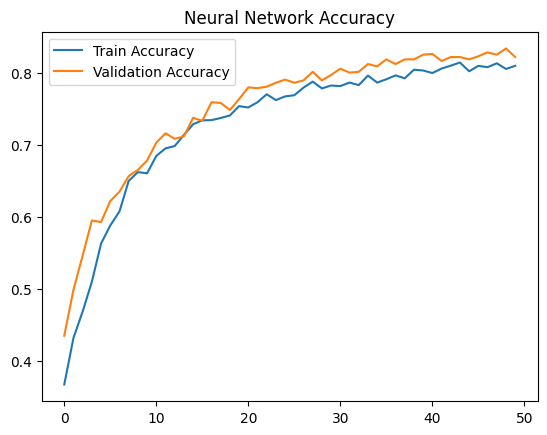

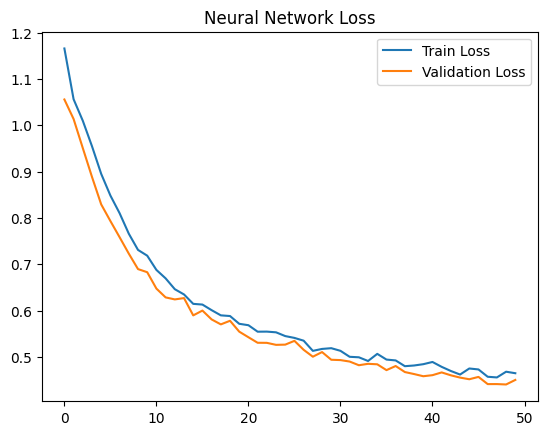

In [32]:
# Build the Neural Network model
model = keras.Sequential([
layers.Dense(32, activation='relu', input_dim=X_train.shape[1]), # Hidden layer with 32 neurons
layers.Dropout(0.2), # Dropout layer to prevent overfitting
layers.Dense(16, activation='relu'), # Hidden layer with 32 neurons
layers.Dropout(0.2), # Dropout layer to prevent overfitting
layers.Dense(3, activation='softmax') # Output layer, softmax for 3 class
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train_encoded, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# Make predictions on test set
y_pred_probs = model.predict(X_test)
y_pred = tf.argmax(y_pred_probs, axis=1).numpy()
y_test_labels = tf.argmax(y_test_encoded, axis=1).numpy()

# Evaluate on the test set
nn_test_accuracy = accuracy_score(y_test_labels, y_pred)
nn_precision = precision_score(y_test_labels, y_pred, average='weighted')
nn_recall = recall_score(y_test_labels, y_pred, average='weighted')
nn_f1 = f1_score(y_test_labels, y_pred, average='weighted')
nn_roc_auc = roc_auc_score(y_test_labels, y_pred_probs, multi_class='ovr', average='weighted')

print(f"Test Accuracy: {nn_test_accuracy * 100:.2f}%")
print(f"Test Precision: {nn_precision * 100:.2f}%")
print(f"Test Recall: {nn_recall * 100:.2f}%")
print(f"Test F1 Score: {nn_f1 * 100:.2f}%")
print(f"Test ROC AUC Score: {nn_roc_auc * 100:.2f}%")

# Confusion matrix as heatmap, to improve interpretability
conf_matrix = confusion_matrix(y_test_labels, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Neural Network Confusion Matrix')
plt.show()

print("Classification Report:")
print(classification_report(y_test_labels, y_pred, target_names=class_labels))

# Plot the train and validation loss
# Train and validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Neural Network Accuracy')
plt.show()

# Train and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Neural Network Loss')
plt.show()